# Uploading data  from Kaggle


Instruction for installing Kaggle API:
https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [3]:
! kaggle competitions download -c 'journey-springfield'
! unzip './journey-springfield'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/simpsons_dataset/moe_szyslak/pic_1025.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1036.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1037.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1038.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pi

In [4]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 409 kB 35.8 MB/s 


In [5]:
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchmetrics import F1Score

import numpy as np
from sklearn.metrics import f1_score
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

In [6]:
transform = transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                     [0.229, 0.224, 0.225])
                                ])

dataset = datasets.ImageFolder('./train/simpsons_dataset',
                                          transform=transform)

train_set, test_set = torch.utils.data.random_split(
    dataset, [int(len(dataset)*0.7), len(dataset)-int(len(dataset)*0.7)])

print(f'train len: {len(train_set)}, test_len: {len(test_set)}')


dataloaders = {'train': torch.utils.data.DataLoader(train_set, batch_size=128,
                                                   shuffle=True, num_workers=2),
              'test': torch.utils.data.DataLoader(test_set, batch_size=128,
                                                  shuffle=False, num_workers=2)}

train len: 14653, test_len: 6280


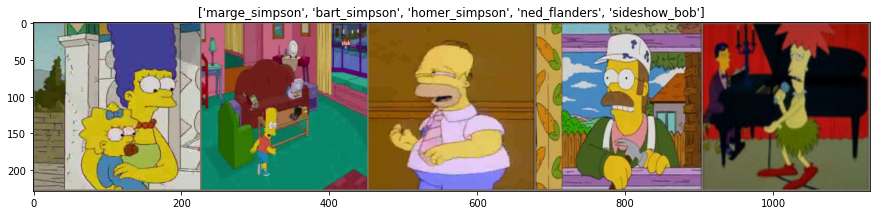

num of classes: 42


In [7]:
# запишем имена классов в переменую class_names
class_names = dataset.classes
# сразу посчитаем количество классов, это и будет количество выходных нейронов
n_classes = len(class_names)

# 
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs[:5])

imshow(out, title=[class_names[x] for x in classes[:5]])
print(f'num of classes: {n_classes}')

In [8]:
model = models.resnet34(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_features = model.fc.in_features

# for param in model.parameters():
#     param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(),
    nn.Linear(num_features, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(1024, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, n_classes)
)

model.to(device)
print(model)
for param in model.parameters():
    print(param.requires_grad)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model.parameters()), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [12]:
max_epochs = 10
accuracy = {"train": [], "test": []}
start_time = time.time()
f1_scores = {"train": [], "test": []}

for epoch in tqdm(range(max_epochs)):
    for k, dataloader in dataloaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in tqdm(dataloader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)                
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = sum(preds == y_batch)
            all = preds.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
            
            f1 = F1Score()
            f1_scores[k].append(f1(preds.cpu(), y_batch.cpu()))

            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
elapsed_time = time.time() - start_time
print(f'elapsed time: {elapsed_time // 60:.0f} mins {elapsed_time % 60:.0f} secs')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.7898723810823722


  0%|          | 0/50 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.9307324840764332


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.9780932232307378


  0%|          | 0/50 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.9441082802547771


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.997133692759162


  0%|          | 0/50 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.9535031847133758


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9997270183580155


  0%|          | 0/50 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.9558917197452229


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9997952637685116


  0%|          | 0/50 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.9585987261146497


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.9998635091790077


  0%|          | 0/50 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.9581210191082803


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9998635091790077


  0%|          | 0/50 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.9578025477707006


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9998635091790077


  0%|          | 0/50 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.9584394904458599


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9998635091790077


  0%|          | 0/50 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.9578025477707006


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9999317545895039


  0%|          | 0/50 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.9593949044585988
elapsed time: 19 mins 50 secs


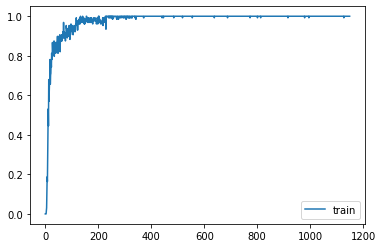

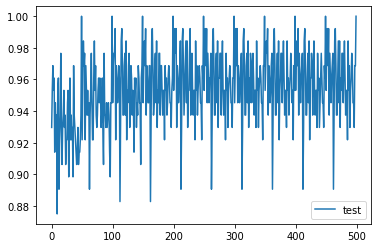

In [27]:
for phase in ['train', 'test']:
    plt.plot(range(len(f1_scores[phase])), f1_scores[phase], label=phase)
    plt.legend()
    plt.show()